In [53]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

定义数据类

In [54]:
class Dataset:
    def __init__(self, mode='given', means1=[-5, 0], means2=[0, 5]):
        if mode == 'given':
            self._given_data()
        if mode == 'random':
            self._rand_sample(means1, means2)

    def _rand_sample(self, means1, means2):
        means1 = np.array(means1)
        means2 = np.array(means2)
        covar = np.array([1, 0, 0, 1]).reshape(2,2)
        x1 = np.random.multivariate_normal(means1, covar, size=200)
        x2 = np.random.multivariate_normal(means2, covar, size=200)
        y1 = np.ones((200, 1))
        y2 = np.ones((200, 1)) * -1
        self._split(x1, y1, x2, y2)

    def _split(self, x1, y1, x2, y2):
        num1 = x1.shape[0]
        train_num1 = int(num1 * 0.8)
        num2 = x2.shape[0]
        train_num2 = int(num2 * 0.8)

        self.x_train = np.concatenate((x1[:train_num1],x2[:train_num2]),axis=0)
        self.y_train = np.concatenate((y1[:train_num1],y2[:train_num2]),axis=0)
        self.x_test = np.concatenate((x1[train_num1:],x2[train_num2:]),axis=0)
        self.y_test = np.concatenate((y1[train_num1:],y2[train_num2:]),axis=0)

    def _given_data(self):
        x = [0.2,0.7,
             0.3,0.3, 
             0.4,0.5, 
             0.6,0.5, 
             0.1,0.4, 
             0.4,0.6, 
             0.6,0.2, 
             0.7,0.4, 
             0.8,0.6, 
             0.7,0.5]
        y = [1,1,1,1,1,-1,-1,-1,-1,-1]
        self.x = np.array(x).reshape(-1,2)
        self.y = np.array(y).reshape(-1,1)
        assert(self.x.shape[0] == self.y.shape[0])

定义模型 PLA算法和其改进的Pocket算法

In [55]:
class PLA(object):
    def __init__(self, dimension):
        super(PLA,self).__init__()
        # zero initialization
        self.dimension = dimension
        self.W = np.zeros((1,dimension))
        self.b = 0
    
    def _update_param(self, x, y):
        self.W += x * y
        self.b += y
        print('W:')
        print(self.W)
        print('b')
        print(self.b)

    def train(self, x, y):
        num, dim = x.shape
        if dim != self.dimension:
            raise
        optimized = False
        while not optimized:
            for i in range(num):
                yhat = np.dot(self.W,x[i]) + self.b
                if yhat * y[i] <= 0:
                    self._update_param(x[i],y[i])
                    break
                # all data classify correctly
                if i == num-1:
                    optimized = True
        print('over training!')

    def inference(self, x, y):
        num, dim = x.shape
        if dim != self.dimension:
            raise
        yhat = np.matmul(self.W,x.transpose(1,0)) + self.b
        yhat = np.sign(yhat).transpose(1,0)
        accuracy = 1 - len(np.nonzero(yhat - y)[0])/len(y)
        print('accuracy: %.2f'%accuracy)

        return yhat

class Pocket(object):
    def __init__(self, dimension):
        super(Pocket,self).__init__()
        # zero initialization
        self.dimension = dimension
        self.W = np.zeros((1,dimension))
        self.b = 0

    def _error_eval(self, w, b, x, y):
        yhat = np.matmul(w, x.transpose(1,0)) + b
        yhat = np.sign(yhat).transpose(1,0)
        a = np.nonzero(yhat - y)
        error_idxs = np.nonzero(yhat - y)[0]

        return len(error_idxs), error_idxs

    def train(self, x, y):
        # init pocket vector
        # chocie = np.random.randint(0,x.shape[0])
        # w = x[chocie].reshape(1,2)
        # b = y[chocie]
        w = np.random.randn(1,2)
        b = np.random.randn(1)
        for i in range(1000):
            error_num, error_idxs = self._error_eval(w, b, x, y)
            if error_num == 0:
                break
            else:
                error_idx = np.random.choice(error_idxs)
                # updata w, b
                error_x = x[error_idx]
                error_y = y[error_idx]
                w_new = w + error_y * error_x
                b_new = b + error_y
                error_num_new, error_idxs_new = self._error_eval(w_new, b_new, x, y)
                if error_num_new <= error_num:
                    # replace w, b with the better one
                    error_num = error_num_new
                    error_idxs = error_idxs_new
                    w = w_new
                    b = b_new
        self.W = w
        self.b = b

    def inference(self, x, y):
        num, dim = x.shape
        if dim != self.dimension:
            raise
        yhat = np.matmul(self.W,x.transpose(1,0)) + self.b
        yhat = np.sign(yhat).transpose(1,0)
        accuracy = 1 - len(np.nonzero(yhat - y)[0])/len(y)
        print('accuracy: %.2f'%accuracy)

        return yhat

首先生成数据

x_train: (320, 2)
y_train: (320, 1)
x_test: (80, 2)
y_test: (80, 1)


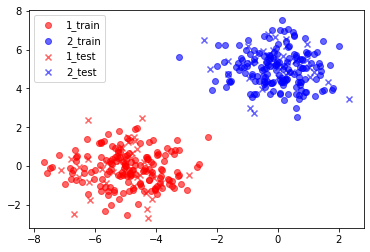

In [56]:
data2 = Dataset(mode='random')
x_train = data2.x_train
y_train = data2.y_train
x_test = data2.x_test
y_test = data2.y_test
print("x_train: {}".format(x_train.shape))
print("y_train: {}".format(y_train.shape))
print("x_test: {}".format(x_test.shape))
print("y_test: {}".format(y_test.shape))
c1 = plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.6, marker='o', c='red')
c2 = plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.6, marker='o', c='blue')
c3 = plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.6, marker='x', c='red')
c4 = plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.6, marker='x', c='blue')
plt.legend(handles=[c1, c2, c3, c4],labels=['1_train','2_train', '1_test', '2_test'],loc='best')
plt.show()

训练PLA模型

In [57]:
classifier = PLA(dimension=2)
start_time = time()
classifier.train(x_train,y_train)
end_time = time()
print('运行时间: %.3f'%(end_time - start_time))

W:
[[-5.48949968 -2.01358765]]
b
[1.]
W:
[[-3.89764753 -6.37205726]]
b
[0.]
W:
[[-6.18858665 -4.89436011]]
b
[1.]
over training!
运行时间: 0.010


测试模型并可视化

accuracy: 1.00


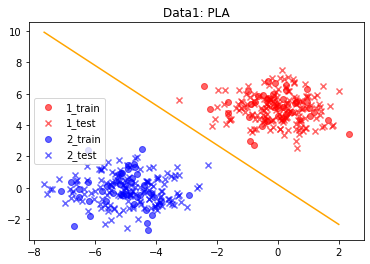

In [58]:
yhat = classifier.inference(x_test,y_test)
w = classifier.W.squeeze()
b = classifier.b

plt.title('PLA classifier')
plt.scatter(x_train[:160,0],x_train[:160,1],alpha=0.6,marker='x',c='blue')
plt.scatter(x_train[160:,0],x_train[160:,1],alpha=0.6,marker='x',c='red')
plt.scatter(x_test[:40,0],x_test[:40,1],alpha=0.6,marker='o',c='blue')
plt.scatter(x_test[40:,0],x_test[40:,1],alpha=0.6,marker='o',c='red')

xmax = np.max(x_train[:,0])
xmin = np.min(x_train[:,0])
point1 = [xmin,xmax]
point2 = [-(w[0]*xmin+b)/w[1],-(w[0]*xmax+b)/w[1]]
plt.plot(point1,point2,c='orange')
plt.legend(handles=[c1, c3, c2, c4],labels=['1_train','1_test','2_train','2_test'],loc='best')
plt.title('Data1: PLA')
plt.show()

采用Pocket算法

In [59]:
classifier = Pocket(dimension=2)
start_time = time()
classifier.train(x_train,y_train)
end_time = time()
print('运行时间: %.3f'%(end_time - start_time))

运行时间: 0.001


测试模型并可视化

accuracy: 1.00


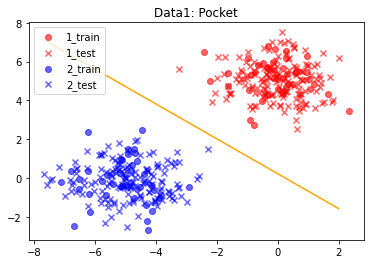

In [60]:
yhat = classifier.inference(x_test,y_test)
w = classifier.W.squeeze()
b = classifier.b

plt.scatter(x_train[:160,0],x_train[:160,1],alpha=0.6,marker='x',c='blue')
plt.scatter(x_train[160:,0],x_train[160:,1],alpha=0.6,marker='x',c='red')
plt.scatter(x_test[:40,0],x_test[:40,1],alpha=0.6,marker='o',c='blue')
plt.scatter(x_test[40:,0],x_test[40:,1],alpha=0.6,marker='o',c='red')

xmax = np.max(x_train[:,0])
xmin = np.min(x_train[:,0])
point1 = [xmin,xmax]
point2 = [-(w[0]*xmin+b)/w[1],-(w[0]*xmax+b)/w[1]]
plt.plot(point1,point2,c='orange')
plt.legend(handles=[c1, c3, c2, c4],labels=['1_train','1_test','2_train','2_test'],loc='best')
plt.title('Data1: Pocket')
plt.show()

改变数据集

x_train: (320, 2)
y_train: (320, 1)
x_test: (80, 2)
y_test: (80, 1)


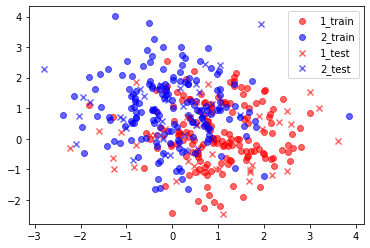

In [61]:
data2 = Dataset(mode='random', means1=[1,0], means2=[0,1])
x_train = data2.x_train
y_train = data2.y_train
x_test = data2.x_test
y_test = data2.y_test
print("x_train: {}".format(x_train.shape))
print("y_train: {}".format(y_train.shape))
print("x_test: {}".format(x_test.shape))
print("y_test: {}".format(y_test.shape))
c1 = plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.6, marker='o', c='red')
c2 = plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.6, marker='o', c='blue')
c3 = plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.6, marker='x', c='red')
c4 = plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.6, marker='x', c='blue')
plt.legend(handles=[c1, c2, c3, c4],labels=['1_train','2_train', '1_test', '2_test'],loc='best')
plt.show()

PLA算法无法收敛，故使用Pocket算法

In [62]:
classifier = Pocket(dimension=2)
start_time = time()
classifier.train(x_train,y_train)
end_time = time()
print('运行时间: %.3f'%(end_time - start_time))

运行时间: 0.094


accuracy: 0.66


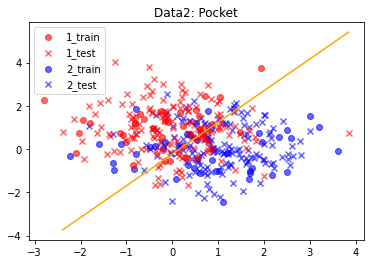

In [63]:
yhat = classifier.inference(x_test,y_test)
w = classifier.W.squeeze()
b = classifier.b

plt.scatter(x_train[:160,0],x_train[:160,1],alpha=0.6,marker='x',c='blue')
plt.scatter(x_train[160:,0],x_train[160:,1],alpha=0.6,marker='x',c='red')
plt.scatter(x_test[:40,0],x_test[:40,1],alpha=0.6,marker='o',c='blue')
plt.scatter(x_test[40:,0],x_test[40:,1],alpha=0.6,marker='o',c='red')

xmax = np.max(x_train[:,0])
xmin = np.min(x_train[:,0])
point1 = [xmin,xmax]
point2 = [-(w[0]*xmin+b)/w[1],-(w[0]*xmax+b)/w[1]]
plt.plot(point1,point2,c='orange')
plt.legend(handles=[c1, c3, c2, c4],labels=['1_train','1_test','2_train','2_test'],loc='best')
plt.title('Data2: Pocket')
plt.show()

显然，PLA算法的局限性在于对于非线性可分的数据无法收敛，而Pocket算法可以在线性不可分时，尽可能的进行分类